In [322]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer 

In [323]:
df=pd.read_csv('2016_Building_Energy_Benchmarking.csv')


In [324]:
## sélection des batiments non résidentiels et 
## répondant aux  exigences d'analyse comparative énergétique pour l'année de déclaration en cours.
df=df[(df['ComplianceStatus']=='Compliant')&(~df['BuildingType'].str.contains('Multifamily')) & (~df['PrimaryPropertyType'].str.contains('Multifamily'))]
df.shape


(1546, 46)

In [325]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [326]:
## recherche de doublons
df['OSEBuildingID']=df['OSEBuildingID'].astype(str)
df['Latitude']=df['Latitude'].astype(str)
df['Longitude']=df['Longitude'].astype(str)

duplicate = df[df.duplicated('OSEBuildingID')]
duplicate ## aucun doublon

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity


# Partie 1 nettoyage des colonnes

### 1-1 <u>Suppression des colonnes avec taux de complétion inférieur à 50%</u>

In [327]:
## fonction renvoyant les colonnes et le pourcentage de valeurs nulles pour chacune d'elle
def columns_na_percentage(df):
    na_df=(df.isnull().sum()/len(df)*100).sort_values(ascending=False).reset_index()
    na_df.columns = ['Column','na_rate_percent']
    return na_df

In [328]:
## variables comportant plus de 50% de valeurs manquantes
na_df=columns_na_percentage(df)
na_columns=na_df[na_df['na_rate_percent']>=50] ## 7 colonnes ont plus de 50% de valeurs nulles
na_columns

,Column,na_rate_percent
0,Outlier,100.000000
1,Comments,100.000000
2,YearsENERGYSTARCertified,93.725744
3,ThirdLargestPropertyUseType,77.554981
4,ThirdLargestPropertyUseTypeGFA,77.554981


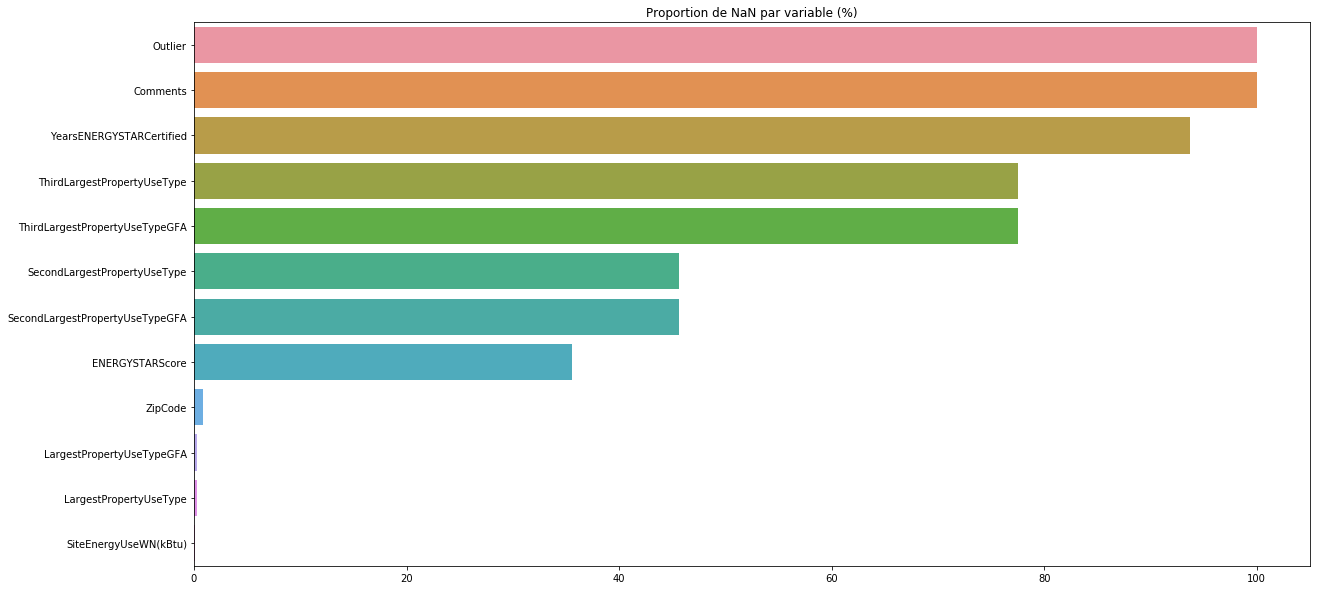

In [329]:
data_nan = df.isna().sum().sort_values(ascending=False).head(12)
plt.title('Proportion de NaN par variable (%)')
sns.barplot(x=data_nan.values/df.shape[0]*100, y=data_nan.index)

In [330]:
## suppression des colonnes ayant plus 50% de valeurs nulles
df.drop(columns=na_columns['Column'].tolist(),axis=1,inplace=True)
df.shape

(1546, 41)

### 1-2 <u>Sélection des variables qualitatives</u>

In [331]:
numeric_columns=df.select_dtypes(exclude=['object']).columns.tolist()
categorical_columns=df.select_dtypes(include=['object']).columns.tolist()
df[categorical_columns].isnull().sum()/len(df)*100

OSEBuildingID                     0.000000
BuildingType                      0.000000
PrimaryPropertyType               0.000000
PropertyName                      0.000000
Address                           0.000000
City                              0.000000
State                             0.000000
TaxParcelIdentificationNumber     0.000000
Neighborhood                      0.000000
Latitude                          0.000000
Longitude                         0.000000
ListOfAllPropertyUseTypes         0.000000
LargestPropertyUseType            0.258732
SecondLargestPropertyUseType     45.601552
ComplianceStatus                  0.000000
dtype: float64

In [332]:
relevant_categorical_columns=[
    'OSEBuildingID',
    'BuildingType',
    'PrimaryPropertyType',
    'PropertyName',
    'Neighborhood',
    'Latitude',
    'Longitude'
]

### 1-3 <u>Sélection des variables quantitatives</u>

In [333]:
numeric_columns=df.select_dtypes(exclude=['object']).columns.tolist()
df[numeric_columns].isnull().sum()/len(df)*100

DataYear                            0.000000
ZipCode                             0.840880
CouncilDistrictCode                 0.000000
YearBuilt                           0.000000
NumberofBuildings                   0.000000
NumberofFloors                      0.000000
PropertyGFATotal                    0.000000
PropertyGFAParking                  0.000000
PropertyGFABuilding(s)              0.000000
LargestPropertyUseTypeGFA           0.258732
SecondLargestPropertyUseTypeGFA    45.601552
ENERGYSTARScore                    35.575679
SiteEUI(kBtu/sf)                    0.000000
SiteEUIWN(kBtu/sf)                  0.064683
SourceEUI(kBtu/sf)                  0.000000
SourceEUIWN(kBtu/sf)                0.000000
SiteEnergyUse(kBtu)                 0.000000
SiteEnergyUseWN(kBtu)               0.064683
SteamUse(kBtu)                      0.000000
Electricity(kWh)                    0.000000
Electricity(kBtu)                   0.000000
NaturalGas(therms)                  0.000000
NaturalGas

In [334]:
relevant_numeric_columns=[
    'GHGEmissionsIntensity',
    'TotalGHGEmissions',
    'NaturalGas(kBtu)',
    'Electricity(kBtu)',
    'SteamUse(kBtu)',
    'SiteEnergyUse(kBtu)',
    'SourceEUI(kBtu/sf)',
    'SiteEUI(kBtu/sf)',
    'ENERGYSTARScore',
   'PropertyGFATotal',
    'NumberofFloors',
    'NumberofBuildings',
    'YearBuilt'
]

In [335]:
df=df[relevant_categorical_columns+relevant_numeric_columns]
df.shape

(1546, 20)

# Partie 2 nettoyage des lignes

In [336]:
## identification et suppression des valeurs numériques négatives sauf pour les colonnes latitude et longitude
negative_cols=[]

for col in relevant_numeric_columns:
    if len(df[df[col]<0])>0:
        negative_cols.append(col)

print('columns with negative values',negative_cols)
for col in negative_cols:
    df.drop(index=df.loc[df[col]<0,col].index,inplace=True)

df.shape

columns with negative values ['GHGEmissionsIntensity', 'TotalGHGEmissions', 'Electricity(kBtu)']


(1545, 20)

# Partie 3 analyse de la multicolinéarité des variables quantitatives

## 3-1 matrice de corrélation

In [337]:
## fonction qui trace la matrice de corrélation
def show_correlation_matrix(relevant_numeric_columns):
    corr_matrix = df[[item for item in relevant_numeric_columns if item!='YearBuilt']].corr()
    fig = plt.figure(1, figsize=(14, 14))

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix, mask=mask, square=True, linewidths=0.1, annot=True)
    plt.xlim(0, corr_matrix.shape[1])
    plt.ylim(0, corr_matrix.shape[0])
    plt.show()

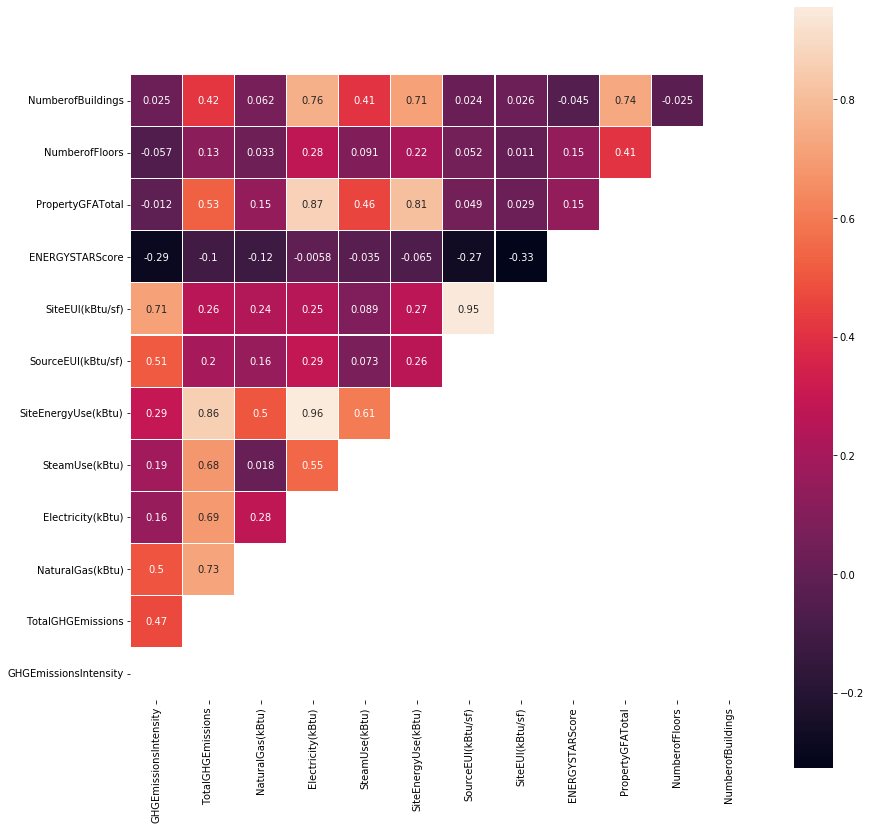

In [338]:
show_correlation_matrix(relevant_numeric_columns)

In [339]:

def corr_matrix(relevant_numeric_columns):
    corr_matrix = df[relevant_numeric_columns].corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False))
    sol=sol[sol>0.5]
    print(sol)

In [340]:
corr_matrix(relevant_numeric_columns)

Electricity(kBtu)      SiteEnergyUse(kBtu)    0.956264
SourceEUI(kBtu/sf)     SiteEUI(kBtu/sf)       0.946487
Electricity(kBtu)      PropertyGFATotal       0.868560
TotalGHGEmissions      SiteEnergyUse(kBtu)    0.860011
SiteEnergyUse(kBtu)    PropertyGFATotal       0.809619
Electricity(kBtu)      NumberofBuildings      0.759651
PropertyGFATotal       NumberofBuildings      0.740139
TotalGHGEmissions      NaturalGas(kBtu)       0.725563
SiteEnergyUse(kBtu)    NumberofBuildings      0.714177
GHGEmissionsIntensity  SiteEUI(kBtu/sf)       0.712885
TotalGHGEmissions      Electricity(kBtu)      0.686515
                       SteamUse(kBtu)         0.684055
SteamUse(kBtu)         SiteEnergyUse(kBtu)    0.605255
Electricity(kBtu)      SteamUse(kBtu)         0.548153
TotalGHGEmissions      PropertyGFATotal       0.527081
GHGEmissionsIntensity  SourceEUI(kBtu/sf)     0.512910
NaturalGas(kBtu)       SiteEnergyUse(kBtu)    0.503097
dtype: float64


In [341]:
numeric_col_to_remove=['Electricity(kBtu)','SourceEUI(kBtu/sf)']

for col in numeric_col_to_remove:
    relevant_numeric_columns.remove(col)

In [342]:
df=df[relevant_categorical_columns+relevant_numeric_columns]
df.shape

(1545, 18)

# Partie 4 Identification des valeurs aberrantes par IQR

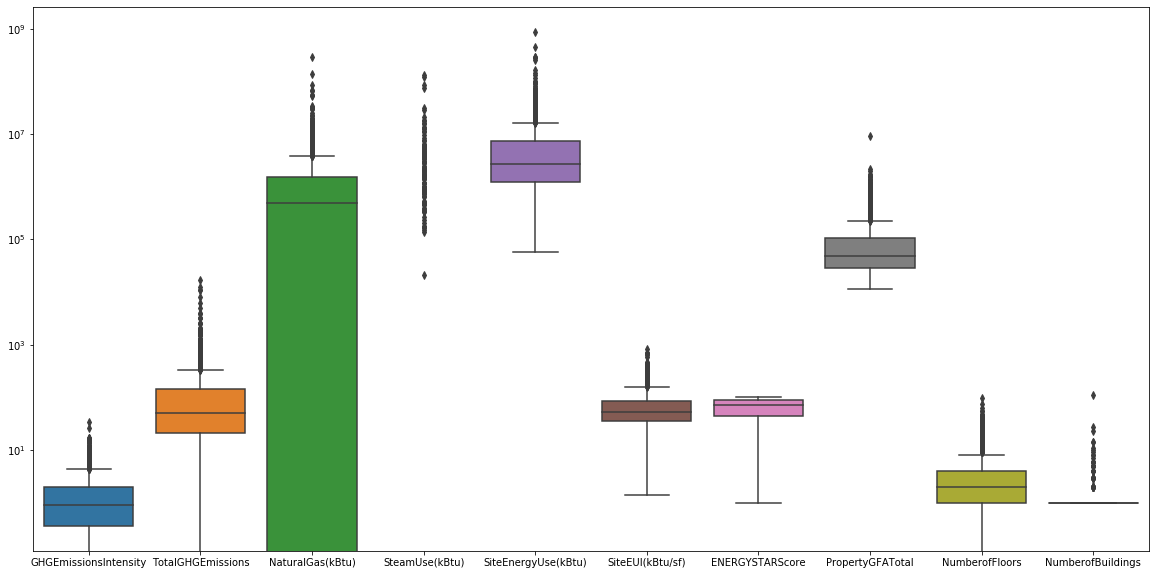

In [343]:

#df[numeric_columns_2].describe()

## afin de détecter d'éventuelles valeurs aberrantes, 
## nous traçons les boxplot pour  chaque variable nutnumérique

## boxplot
from matplotlib import rcParams

rcParams['figure.figsize'] = 20,10
g=sns.boxplot(data=df[[item for item in relevant_numeric_columns if item!='YearBuilt']])
g.set_yscale("log")

## présence de plusieurs valeurs aberrantes 

In [344]:
## fonction qui calcule les valeurs aberrantes sur un échantillon homogène de même année de construction
 # et   renvoit les noms des batiments sous forme de liste
    
def find_outliers(col,data):
    sorted_data=np.sort(data[col])
    Q3 = np.quantile(sorted_data, 0.75)
    Q1 = np.quantile(sorted_data, 0.25)
    IQR = Q3 - Q1   
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in sorted_data if (
        (x < lower_range)| (x > upper_range))]
    #print('outlier_free_list',outlier_free_list)
    outliers = data.loc[data[col].isin(outlier_free_list)]
    #print('outliers',outliers['product_name'])
    
    if len(outliers)>0:
        outliers=outliers['OSEBuildingID'].values.tolist()
        return  list(map(lambda x: (x,col), outliers))
    else:
        return []

In [345]:

outliers=[]
group_by_col='BuildingType'
relevant_cols_iqr=[item for item in relevant_numeric_columns if item!='YearBuilt' and item!=group_by_col]

print('relevant_cols_iqr',relevant_cols_iqr)
for category in df[group_by_col].unique():
    for col in relevant_cols_iqr:
        data=df[df[group_by_col]==category][[col,'OSEBuildingID',group_by_col]]
        if len(data)>0:
            outliers=outliers+find_outliers(col,df)
        
        
        
print(outliers) ## si on se réfère au type de batiment non résidentiel , il y a 6720 valeurs aberrantes

relevant_cols_iqr ['GHGEmissionsIntensity', 'TotalGHGEmissions', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)', 'ENERGYSTARScore', 'PropertyGFATotal', 'NumberofFloors', 'NumberofBuildings']
[('5', 'GHGEmissionsIntensity'), ('15', 'GHGEmissionsIntensity'), ('17', 'GHGEmissionsIntensity'), ('19', 'GHGEmissionsIntensity'), ('24', 'GHGEmissionsIntensity'), ('27', 'GHGEmissionsIntensity'), ('43', 'GHGEmissionsIntensity'), ('60', 'GHGEmissionsIntensity'), ('84', 'GHGEmissionsIntensity'), ('85', 'GHGEmissionsIntensity'), ('96', 'GHGEmissionsIntensity'), ('147', 'GHGEmissionsIntensity'), ('338', 'GHGEmissionsIntensity'), ('198', 'GHGEmissionsIntensity'), ('224', 'GHGEmissionsIntensity'), ('233', 'GHGEmissionsIntensity'), ('268', 'GHGEmissionsIntensity'), ('276', 'GHGEmissionsIntensity'), ('282', 'GHGEmissionsIntensity'), ('314', 'GHGEmissionsIntensity'), ('318', 'GHGEmissionsIntensity'), ('365', 'GHGEmissionsIntensity'), ('381', 'GHGEmissionsIntensity'), ('389

In [346]:
import collections
outliers_names=list(map(lambda x: x[0],outliers))

print('len first ',len(outliers_names)) ##84956
duplicates=[item for item, count in collections.Counter(outliers_names).items() if count > 1] 
## 16549 produits ayant plus d'une valeur aberrante pour les variables nutritives
print('duplicates',len(duplicates))
#list(collections.OrderedDict.fromkeys(product_outliers_names))

len first  6720
duplicates 525


In [347]:
## création de nouvelles colonnes pour identifier les outliers
cols_ouliers=list(map(lambda x:x+'_outliers',relevant_cols_iqr))
for col in cols_ouliers:
    df[col]=0


In [348]:
## identification des outliers
for i,col in outliers:
    building=df[df['OSEBuildingID']==i]
    df.loc[building.index,col+'_outliers']=1

In [349]:
df.to_csv('./2016_Building_Energy_Benchmarking_outliers.csv',index=False)

In [350]:
## identification des 525 batiments ayant des valeurs aberrantes
outliers_df=df[df['OSEBuildingID'].isin(outliers_names)][['PropertyName','OSEBuildingID','YearBuilt']] 
outliers_df

,PropertyName,OSEBuildingID,YearBuilt
0,Mayflower park hotel,1,1927
1,Paramount Hotel,2,1996
2,5673-The Westin Seattle,3,1969
3,HOTEL MAX,5,1926
4,WARWICK SEATTLE HOTEL (ID8),8,1980
...,...,...,...
3339,Airport - Main Terminal,50069,1929
3356,AIBS,50094,2015
3365,Ballard Pool,50208,1972
3367,Conservatory Campus,50212,1912


In [351]:
## suppression des valeurs aberrantes
df.drop(outliers_df.index,inplace=True)

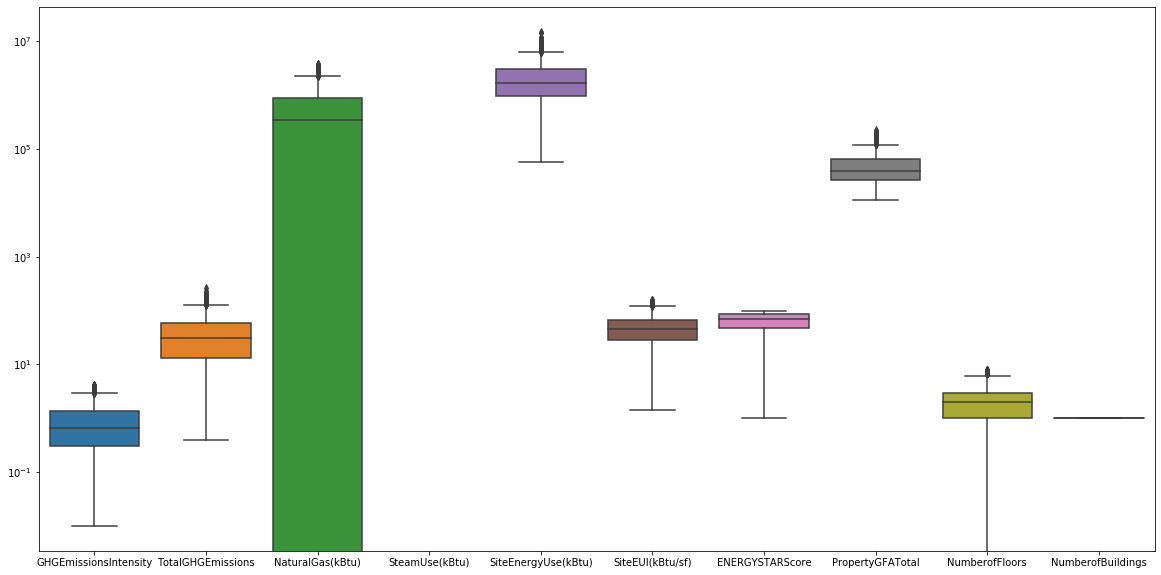

In [352]:
rcParams['figure.figsize'] = 20,10
g=sns.boxplot(data=df[[item for item in relevant_numeric_columns if item!='YearBuilt']])
g.set_yscale("log")


# Partie 5 Imputation des valeurs manquantes

In [353]:
df.isnull().sum()/len(df)*100

OSEBuildingID                      0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
PropertyName                       0.000000
Neighborhood                       0.000000
Latitude                           0.000000
Longitude                          0.000000
GHGEmissionsIntensity              0.000000
TotalGHGEmissions                  0.000000
NaturalGas(kBtu)                   0.000000
SteamUse(kBtu)                     0.000000
SiteEnergyUse(kBtu)                0.000000
SiteEUI(kBtu/sf)                   0.000000
ENERGYSTARScore                   33.529412
PropertyGFATotal                   0.000000
NumberofFloors                     0.000000
NumberofBuildings                  0.000000
YearBuilt                          0.000000
GHGEmissionsIntensity_outliers     0.000000
TotalGHGEmissions_outliers         0.000000
NaturalGas(kBtu)_outliers          0.000000
SteamUse(kBtu)_outliers            0.000000
SiteEnergyUse(kBtu)_outliers    

In [354]:
imputer = KNNImputer()
data=np.array(df['ENERGYSTARScore']).reshape((len(df['ENERGYSTARScore']), 1))

df['ENERGYSTARScore']=imputer.fit_transform(data)


In [355]:
df.isnull().sum()/len(df)*100

OSEBuildingID                     0.0
BuildingType                      0.0
PrimaryPropertyType               0.0
PropertyName                      0.0
Neighborhood                      0.0
Latitude                          0.0
Longitude                         0.0
GHGEmissionsIntensity             0.0
TotalGHGEmissions                 0.0
NaturalGas(kBtu)                  0.0
SteamUse(kBtu)                    0.0
SiteEnergyUse(kBtu)               0.0
SiteEUI(kBtu/sf)                  0.0
ENERGYSTARScore                   0.0
PropertyGFATotal                  0.0
NumberofFloors                    0.0
NumberofBuildings                 0.0
YearBuilt                         0.0
GHGEmissionsIntensity_outliers    0.0
TotalGHGEmissions_outliers        0.0
NaturalGas(kBtu)_outliers         0.0
SteamUse(kBtu)_outliers           0.0
SiteEnergyUse(kBtu)_outliers      0.0
SiteEUI(kBtu/sf)_outliers         0.0
ENERGYSTARScore_outliers          0.0
PropertyGFATotal_outliers         0.0
NumberofFloo

# Partie 6 feature engineering

### 6-1 recherche des variables dont les valeurs sont constantes

In [366]:
static_cols=[]
for col in relevant_numeric_columns:
    if df[col].nunique(col)==1:
        static_cols.append(col)
        relevant_numeric_columns.remove(col)
        
static_cols

[]

### 6-2 création de la variable  âge à partir de l'année de construction

In [367]:
df['YearBuilt']=2016-df['YearBuilt']

df.rename(columns = {'YearBuilt':'age'}, inplace = True)
relevant_numeric_columns.append('age')
relevant_numeric_columns.remove('YearBuilt')

KeyError: 'YearBuilt'

In [368]:
df[relevant_numeric_columns].corr()

,GHGEmissionsIntensity,TotalGHGEmissions,NaturalGas(kBtu),SiteEnergyUse(kBtu),SiteEUI(kBtu/sf),ENERGYSTARScore,PropertyGFATotal,NumberofFloors,age
GHGEmissionsIntensity,1.000000,0.708313,0.783287,0.214404,0.575953,-0.172666,-0.208385,-0.132731,0.045422
TotalGHGEmissions,0.708313,1.000000,0.949863,0.671296,0.519600,-0.081343,0.362331,0.141105,-0.056022
NaturalGas(kBtu),0.783287,0.949863,1.000000,0.406606,0.384538,-0.050130,0.165512,0.014342,0.006086
SiteEnergyUse(kBtu),0.214404,0.671296,0.406606,1.000000,0.610764,-0.118969,0.664923,0.377241,-0.174951
SiteEUI(kBtu/sf),0.575953,0.519600,0.384538,0.610764,1.000000,-0.347859,0.025918,0.139937,-0.109603
ENERGYSTARScore,-0.172666,-0.081343,-0.050130,-0.118969,-0.347859,1.000000,0.128992,0.109629,0.051390
PropertyGFATotal,-0.208385,0.362331,0.165512,0.664923,0.025918,0.128992,1.000000,0.417748,-0.208845
NumberofFloors,-0.132731,0.141105,0.014342,0.377241,0.139937,0.109629,0.417748,1.000000,0.040477
age,0.045422,-0.056022,0.006086,-0.174951,-0.109603,0.051390,-0.208845,0.040477,1.000000
